In [1]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms

from torch.utils.data import DataLoader
from torchvision.datasets import CIFAR10

from cka import IncrementalCKA

The data and model definitions are based on the pytorch's tutorial: https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html

In [2]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# increase batch size from 4
batch_size = 256

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)

testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=True, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


In [3]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()

In [4]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9)

## Training

In [5]:
for epoch in range(3):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 100 == 99:    # print every 100 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 100))
            running_loss = 0.0

print('Finished Training')

[1,   100] loss: 2.296
[2,   100] loss: 1.910
[3,   100] loss: 1.634
Finished Training


## Testing

In [6]:
correct = 0
total = 0

# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data
        # calculate outputs by running images through the network
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))


Accuracy of the network on the 10000 test images: 45 %


## Calculate mini-batched CKA between intermediate representations in the trained network step by step

Suppose we have two matrices:
1. `X`: intermediate representations in $ \mathbb{R}^{n \times p_1}$,
2. `Y`: intermediate representations in $ \mathbb{R}^{n \times p_2}$,

where $n$ is the number of samples in a mini-batch, and $p_1$ and $p_2$ are the dimesionality of feature representations.

To calculate cka score for a pair of intermediate representations, we call `IncrementalCKA.increment_cka_score` with the following arguments. 

1. `X`
1. `Y`
1. the index of layer to compute `X` in $[0, \ldots, \texttt{num_representations}]$
1. the index of layer to compute `Y` in $[0, \ldots, \texttt{num_representations}]$

Recall that we are going to calculate similarity between representations in the following model:

```python
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

```

Concretely, we use the following representations:

- after every conv2d
- after every linear 2d


`IncrementalCKA` computes cka value given a pair of two intermediate representations,
so we need to specify the number of representations (or mightbe the number of intermediate layers) for initialisation.

In [7]:
num_representations = 5
print("num representations:", num_representations)

incremental_cka = IncrementalCKA(num_representations, num_representations)

num representations: 5


To get intermediate value, this notebook uses [`register_module_forward_hook`](https://pytorch.org/docs/stable/generated/torch.nn.modules.module.register_module_forward_hook.html):



In [8]:
def tensor_to_flatten_numpy(tensor):
    
    return tensor.flatten(start_dim=1).numpy()

def get_intermediate(module, input, outputs):
    
    global intermediates
    intermediates.append(tensor_to_flatten_numpy(outputs))
    

In [9]:
handlers = []

handlers.append(net.conv1.register_forward_hook(get_intermediate))
handlers.append(net.conv2.register_forward_hook(get_intermediate))
handlers.append(net.fc1.register_forward_hook(get_intermediate))
handlers.append(net.fc2.register_forward_hook(get_intermediate))
handlers.append(net.fc3.register_forward_hook(get_intermediate))


By calling forward pass with the hook above, `intermediates` stores each intermediate representation.

Due to the randomness of mini-batch, we evalualte the whole test loop $10$ times

In [ ]:
num_iters = 10

with torch.no_grad():
    for _ in range(num_iters):

        for data in testloader:
            
            intermediates = [] # reset intermediate values
            
            images, _ = data
            net(images)  # call forward pass and stores intermediate values
            
            # calculate cka for all pairs of representations
            for index_x, X in enumerate(intermediates):
                for index_y, Y in enumerate(intermediates):
                    incremental_cka.increment_cka_score(index_x, index_y, X, Y
                    )


## visualisation

To access the cka values, we just call `cka` method. `cka` returns a 2d ndarray whose elemet is cka value between two intermediate representations. To unify the appearence with the original cka paper, we need to reverse the ordering of column and its lables as follows:
If you would like to plot several plots with the same heatmap scale for comparision, we recommend specifying the same `vmin` value across different heatmaps.

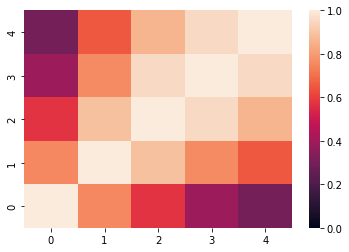

In [12]:
sns.heatmap(incremental_cka.cka()[::-1], yticklabels=range(num_representations-1, -1, -1), vmin=0., vmax=1.0);

### Post-processing

If you re-train the model, remove `register_forward_hook` by calling `remove` method:

In [13]:
for handler in handlers:
    handler.remove()